In [1]:
#!/usr/bin/env pyhton3
# -*- coding 

from sklearn import datasets
from sklearn.model_selection import train_test_split
###-----------------
### Import Libraries
###-----------------
import os
import time
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix
import gc

from sklearn.metrics import mean_squared_error,accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

import warnings
warnings.filterwarnings('ignore')
from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [2]:
# Global variables
inpDir = './input' # Input Stored here
outDir = './ouput' # output Here
modelDir = './models'# to save Models
subDir = 'fashion_mnist' # sub dir by dataset
RANDOM_STATE = 24
np.random.RandomState(seed = RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
#rng = np.random.default_rng(seed = RANDOM_STATE)
#N_SAMPLE = 1000
TEST_SIZE = 0.2 # 18147 - 56*256
ALPHA = 0.001 # learning rate
NOISE = 0.2 # Error
EPOCHS = 30
BATCH_SIZE = 32# default for tensorflow

PATIENCE = 10
LR_FACTOR = 0.1
LR_PATIENCE = 10

In [3]:
#set the plotting parameters
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }
    #'text.usetex':True,

plt.rcParams.update(params)
CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid')


In [4]:
fileName = 'weatherHistory.csv'

data_df = pd.read_csv(os.path.join(inpDir, fileName))
data_df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


<Axes: xlabel='Formatted Date'>

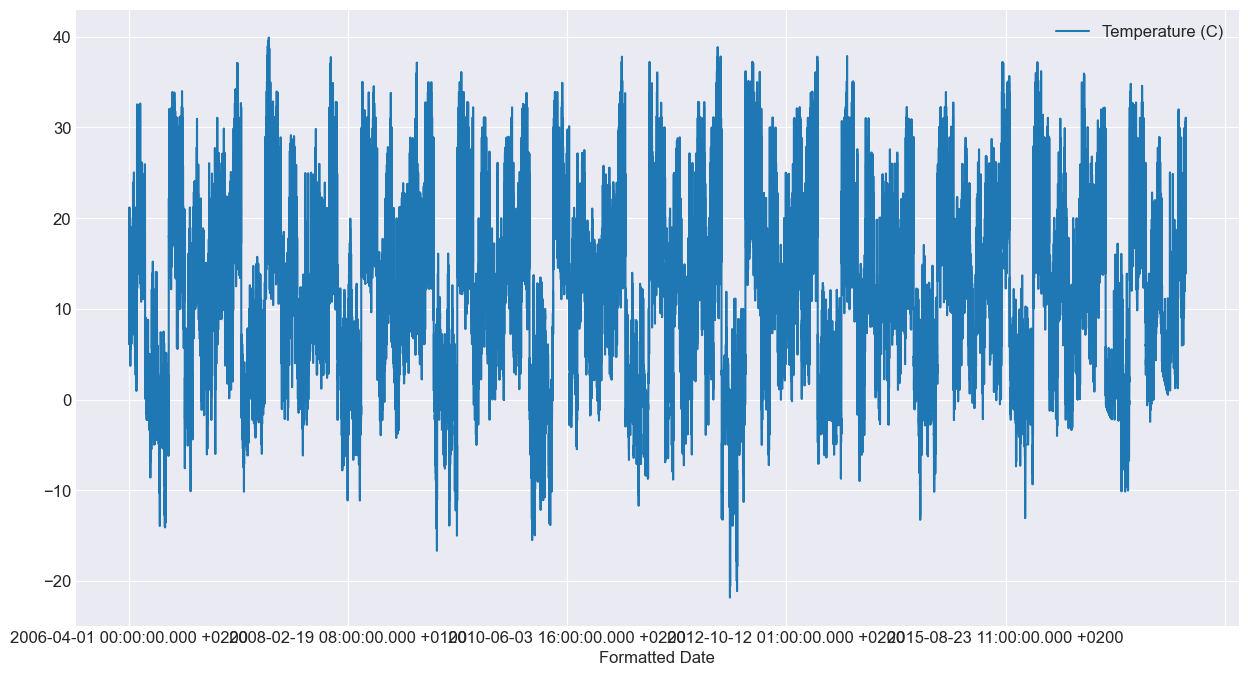

In [5]:
fig, ax = plt.subplots()
data_df.plot(x = 'Formatted Date', y = 'Temperature (C)', ax =ax)


In [6]:
data_df['datetime'] = pd.to_datetime(data_df['Formatted Date'], utc = True)

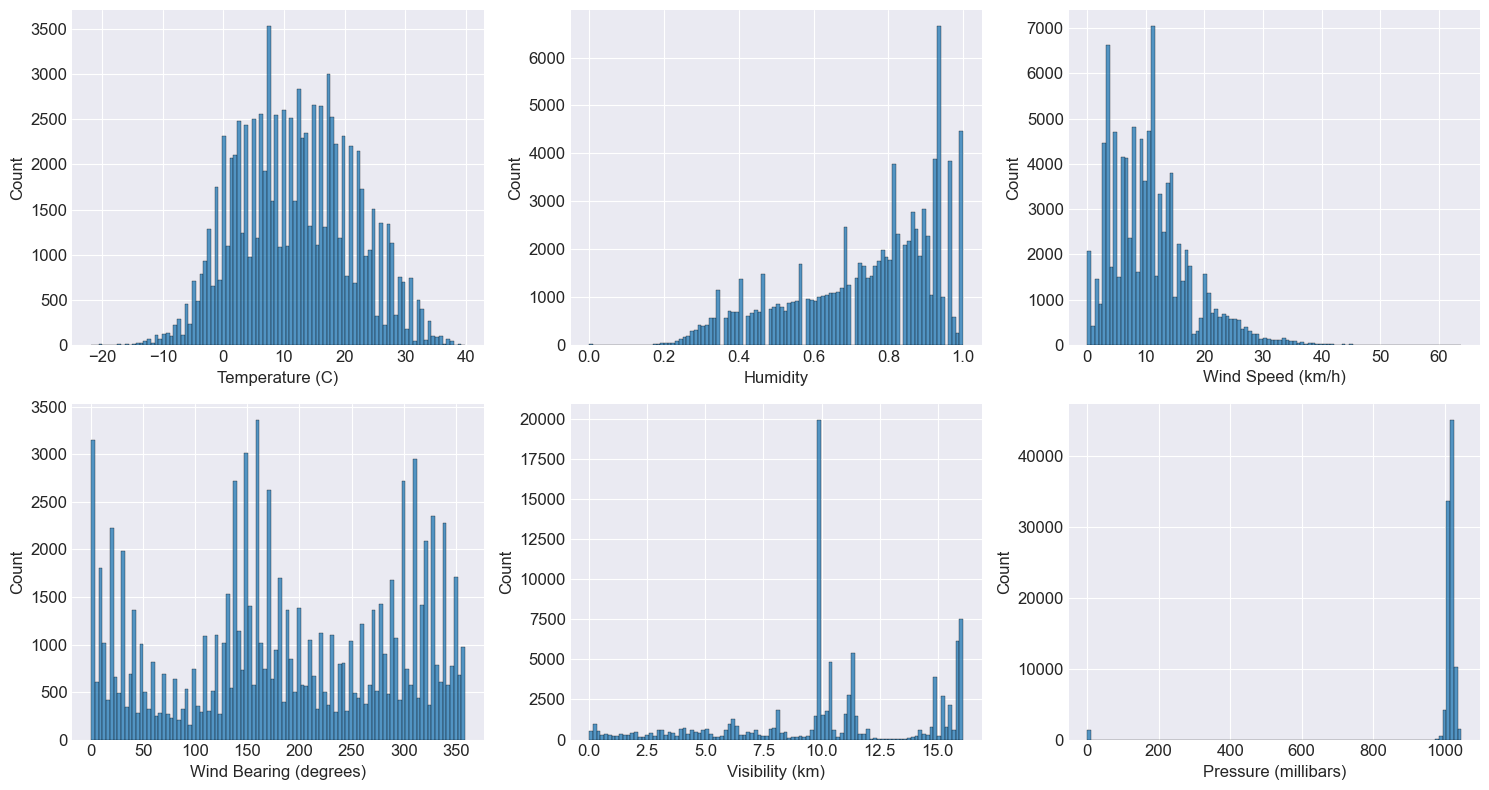

In [7]:
num_cols = ['Temperature (C)',
        'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)']

fig, axes = plt.subplots(2,3 ,figsize = (15,8))
nbin = 100
axes = axes.ravel()
for count,col in enumerate(num_cols):
    ax = axes[count]
    sns.histplot(data = data_df, x = col, ax = ax, bins = nbin)
plt.tight_layout()

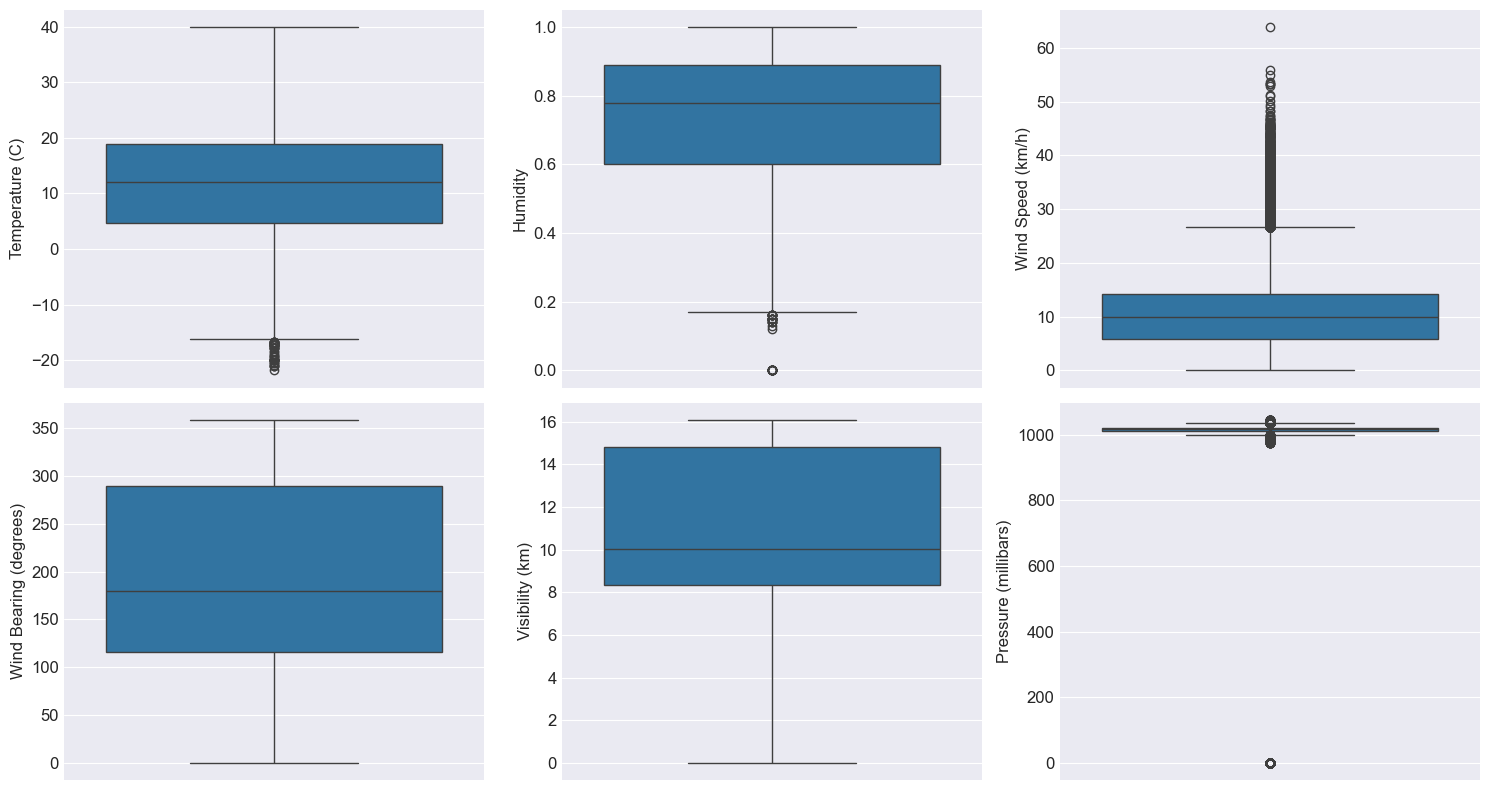

In [8]:
# num_cols = ['Temperature (C)',
#         'Humidity', 'Wind Speed (km/h)',
#        'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover']

fig, axes = plt.subplots(2,3 ,figsize = (15,8))
nbin = 100
axes = axes.ravel()
for count,col in enumerate(num_cols):
    ax = axes[count]
    sns.boxplot(data = data_df, y = col, ax = ax)
plt.tight_layout()

In [9]:
data_df['Loud Cover'].value_counts()

Loud Cover
0.0    96453
Name: count, dtype: int64

In [10]:
data_df.columns

Index(['Formatted Date', 'Summary', 'Precip Type', 'Temperature (C)',
       'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover',
       'Pressure (millibars)', 'Daily Summary', 'datetime'],
      dtype='object')

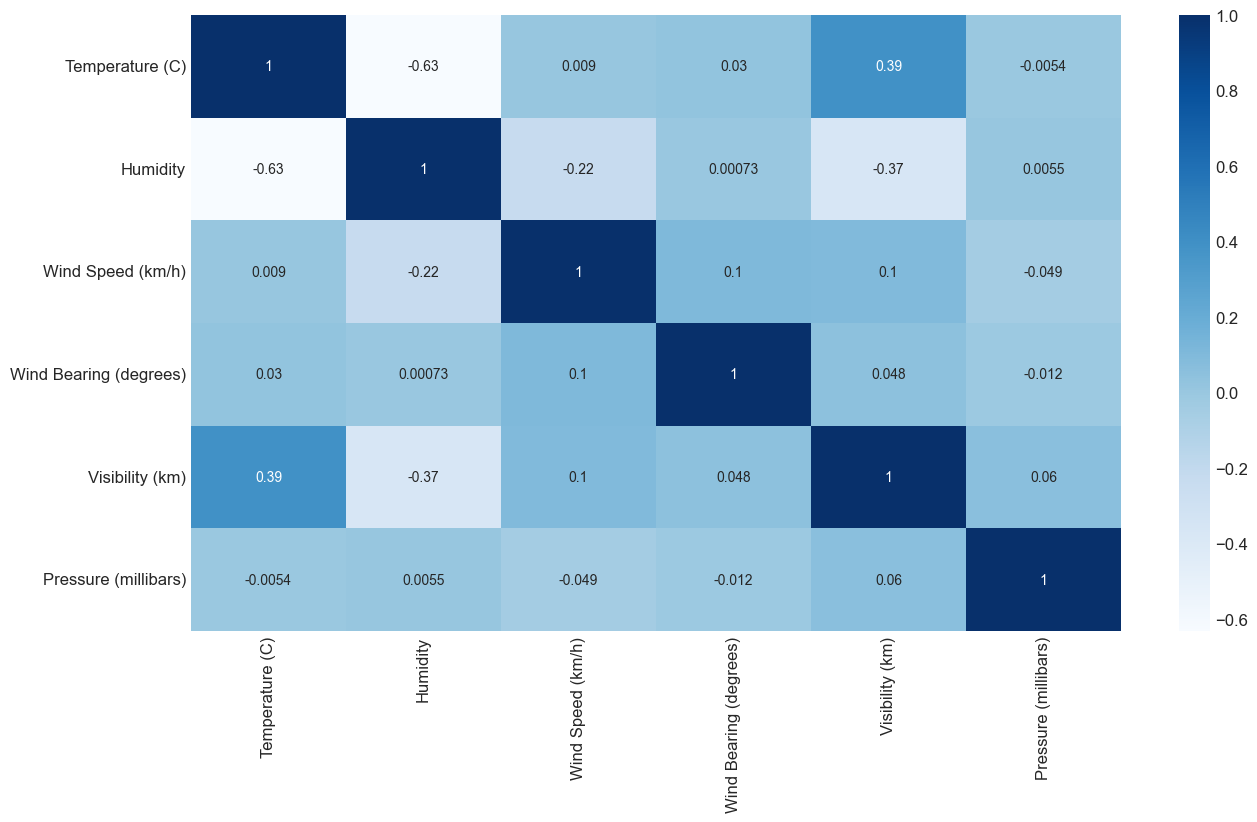

In [11]:
sns.heatmap(data_df[num_cols].corr(), annot = True, cmap = 'Blues');

In [12]:
temp_df = data_df[['datetime', 'Temperature (C)','Humidity', 'Wind Speed (km/h)',
        'Visibility (km)']]
temp_df = temp_df.sort_values('datetime', axis =0, ascending=True)
temp_df = temp_df.reset_index(drop=True)
temp_df = temp_df.rename({'Temperature (C)': 'temp',
                         'Humidity':'hum',
                         'Wind Speed (km/h)':'wind',
                          'Visibility (km)':'vis'
                         }, axis =1)
temp_df.head()

,datetime,temp,hum,wind,vis
0,2005-12-31 23:00:00+00:00,0.577778,0.89,17.1143,9.9820
1,2006-01-01 00:00:00+00:00,1.161111,0.85,16.6152,9.9015
2,2006-01-01 01:00:00+00:00,1.666667,0.82,20.2538,9.9015
3,2006-01-01 02:00:00+00:00,1.711111,0.82,14.4900,9.9015
4,2006-01-01 03:00:00+00:00,1.183333,0.86,13.9426,9.9015


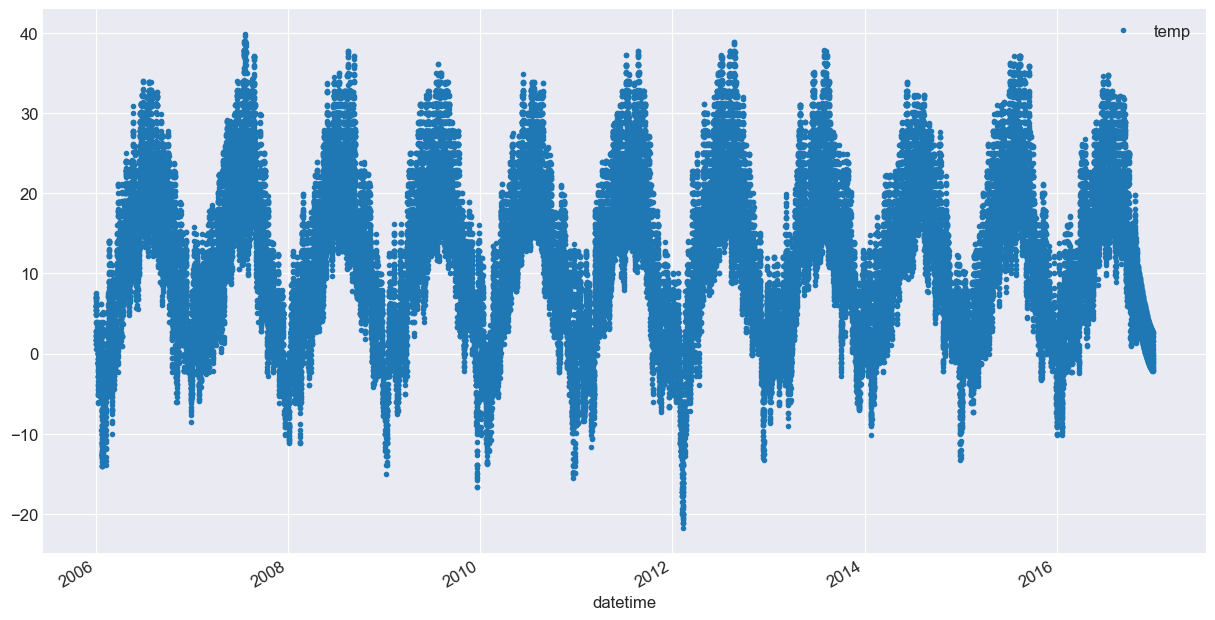

In [13]:
ax = temp_df.plot(x = 'datetime', y='temp', style = '.');


In [14]:
h_units = 100 # hidden layers No. of neurons
input_shape = (1,10000) # inputs 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=input_shape))
model.add(tf.keras.layers.SimpleRNN(units = h_units,
                                   activation='tanh'
                                   ))
model.add(tf.keras.layers.Dense(1,
                                   activation='linear',
                                   
                                   ))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 100)                 │       1,010,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,010,201 (3.85 MB)

 Trainable params: 1,010,201 (3.85 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
for ax in model.get_weights():
    print(ax.shape)
print('\n')
print(f'Wax = {model.get_weights()[0].shape}')
print(f'Waa = {model.get_weights()[1].shape}')
print(f'ba = {model.get_weights()[2].shape}')
print(f'Way = {model.get_weights()[3].shape}')
print(f'by = {model.get_weights()[4].shape}')

(10000, 100)
(100, 100)
(100,)
(100, 1)
(1,)


Wax = (10000, 100)
Waa = (100, 100)
ba = (100,)
Way = (100, 1)
by = (1,)


In [16]:
temp_df

,datetime,temp,hum,wind,vis
0,2005-12-31 23:00:00+00:00,0.577778,0.89,17.1143,9.9820
1,2006-01-01 00:00:00+00:00,1.161111,0.85,16.6152,9.9015
2,2006-01-01 01:00:00+00:00,1.666667,0.82,20.2538,9.9015
3,2006-01-01 02:00:00+00:00,1.711111,0.82,14.4900,9.9015
4,2006-01-01 03:00:00+00:00,1.183333,0.86,13.9426,9.9015
...,...,...,...,...,...
96448,2016-12-31 18:00:00+00:00,0.488889,0.86,9.7566,8.0178
96449,2016-12-31 19:00:00+00:00,0.072222,0.88,9.4185,7.2450
96450,2016-12-31 20:00:00+00:00,-0.233333,0.89,9.2736,9.5795
96451,2016-12-31 21:00:00+00:00,-0.472222,0.91,9.2414,8.4042


In [17]:
time_step = 24
temp_df.shape[0]/time_step


y_idx = np.arange(time_step, temp_df.shape[0], time_step)
y_idx

array([   24,    48,    72, ..., 96384, 96408, 96432])

In [18]:
y_df = temp_df.iloc[y_idx]
y_df.head()

,datetime,temp,hum,wind,vis
24,2006-01-01 23:00:00+00:00,5.422222,0.86,13.6689,15.6492
48,2006-01-02 23:00:00+00:00,1.694444,0.92,20.2216,4.4919
72,2006-01-03 23:00:00+00:00,2.200000,0.89,3.6386,9.5795
96,2006-01-04 23:00:00+00:00,1.666667,0.92,17.3880,9.9015
120,2006-01-05 23:00:00+00:00,1.805556,0.99,4.8139,2.2057


In [19]:
y_df.shape

(4018, 5)

In [20]:
temp_df = temp_df.iloc[range(len(y_df) * time_step)]
temp_df.shape

(96432, 5)

In [21]:
# Reshape to match number of e=rows in y_df

X_temp = np.reshape(temp_df['temp'].values, (y_df.shape[0], time_step))
X_hum = np.reshape(temp_df['hum'].values, (y_df.shape[0], time_step))
X_wind = np.reshape(temp_df['wind'].values, (y_df.shape[0], time_step))
X_vis = np.reshape(temp_df['vis'].values, (y_df.shape[0], time_step))

X_temp.shape, X_hum.shape, X_wind.shape, X_vis.shape

((4018, 24), (4018, 24), (4018, 24), (4018, 24))

In [22]:
# remove last column
X_temp  = X_temp[:, :23]
X_hum = X_hum[:,:23]
X_wind = X_wind[:,:23]
X_vis = X_vis[:,:23]

In [23]:
#X[0], y_df.head(1)

[samples, timesteps, features]

In [25]:
X_data = np.stack((
    X_temp,
    X_hum,X_vis,
    X_wind))
X_data = np.reshape(X_data, (X_temp.shape[0], X_temp.shape[1], 4))
X_data.shape

(4018, 23, 4)

In [26]:
split = int(y_df.shape[0] * (1 - TEST_SIZE))
split

3214

In [27]:
X_train = X_data[:split]
X_test = X_data[split:]
y_train = y_df['temp'].values[:split]
y_test = y_df['temp'].values[split:]

In [28]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3214, 23, 4), (804, 23, 4), (3214,), (804,))

In [29]:
h_units = 256 # hidden layers No. of neurons
input_shape = (time_step - 1,X_train.shape[2]) # inputs  (time_Step, feature )
initializer = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=input_shape))
model.add(tf.keras.layers.SimpleRNN(units = h_units,
                                    kernel_initializer= initializer,
                                       activation='tanh'
                                   ))
model.add(tf.keras.layers.Dense(1,
                                   activation='linear',
                                   
                                   ))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)             │ (None, 256)                 │          66,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,073 (262.00 KB)

 Trainable params: 67,073 (262.00 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model.compile(optimizer = 'adam', # optimisation, loss calculation 
             loss = 'mean_squared_error',
              metrics = [tf.keras.metrics.RootMeanSquaredError(name='RMSE', dtype=None)]
             )
history = model.fit(x = X_train, y = y_train, 
                    validation_data = [X_test, y_test],
                    batch_size = BATCH_SIZE,
                    verbose = 1,
                    epochs =EPOCHS
                   )

Epoch 1/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - RMSE: 8.9691 - loss: 81.1782 - val_RMSE: 7.4073 - val_loss: 54.8674
Epoch 2/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - RMSE: 8.5239 - loss: 72.7058 - val_RMSE: 7.2784 - val_loss: 52.9746
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - RMSE: 8.2212 - loss: 67.6051 - val_RMSE: 7.4305 - val_loss: 55.2116
Epoch 4/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - RMSE: 8.0839 - loss: 65.3671 - val_RMSE: 7.3436 - val_loss: 53.9284
Epoch 5/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - RMSE: 8.1392 - loss: 66.2724 - val_RMSE: 7.4121 - val_loss: 54.9397
Epoch 6/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - RMSE: 8.0741 - loss: 65.2108 - val_RMSE: 7.3009 - val_loss: 53.3024
Epoch 7/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - RMSE: 8.0242 - loss: 64.4036 - val_RMSE: 7.3704 - val_loss: 54.3224
Epoch 8/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - RMSE: 8.0606 - loss: 64.9889 - val_RMSE: 7.4954 - val_loss: 56.1815
Epoch 9/30
101/1

In [31]:
loss_df = pd.DataFrame(history.history)

In [32]:
loss_df

,RMSE,loss,val_RMSE,val_loss
0,8.440591,71.243568,7.407252,54.867382
1,8.431697,71.093513,7.278367,52.974621
2,8.175267,66.834991,7.430453,55.211636
3,8.084188,65.354103,7.343594,53.928368
4,8.128115,66.066254,7.412132,54.939705
5,8.143692,66.319717,7.300850,53.302414
6,8.027778,64.445213,7.370372,54.322388
7,8.033295,64.533829,7.495433,56.181522
8,7.986406,63.782681,7.441917,55.382137
9,7.914898,62.645607,7.302730,53.329868


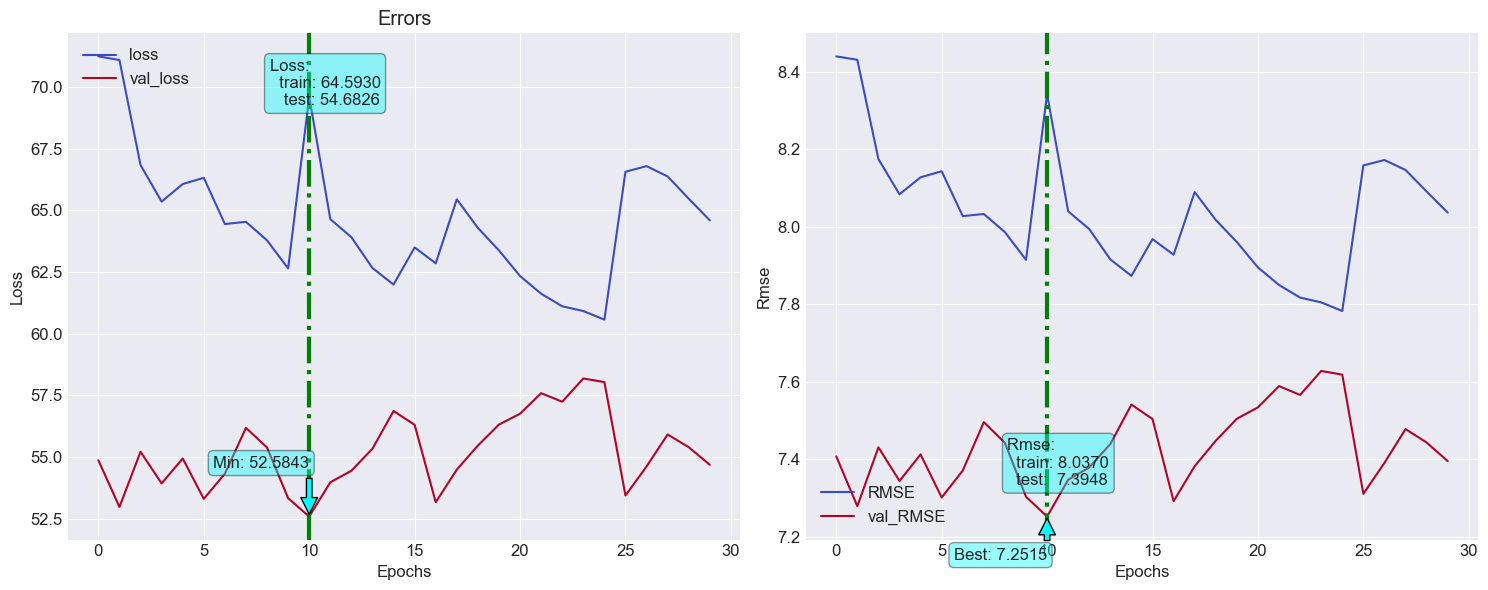

In [33]:
fn_plot_tf_hist(loss_df)

In [34]:
y_tr_pred = model.predict(X_train)
y_ts_pred = model.predict(X_test)

y_pred = np.append(y_tr_pred, y_ts_pred)
res_df = y_df.copy()
res_df['pred'] = y_pred
res_df.head()

101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


,datetime,temp,hum,wind,vis,pred
24,2006-01-01 23:00:00+00:00,5.422222,0.86,13.6689,15.6492,8.583896
48,2006-01-02 23:00:00+00:00,1.694444,0.92,20.2216,4.4919,9.021485
72,2006-01-03 23:00:00+00:00,2.200000,0.89,3.6386,9.5795,-6.023247
96,2006-01-04 23:00:00+00:00,1.666667,0.92,17.3880,9.9015,0.133262
120,2006-01-05 23:00:00+00:00,1.805556,0.99,4.8139,2.2057,-6.063885


<Axes: xlabel='datetime'>

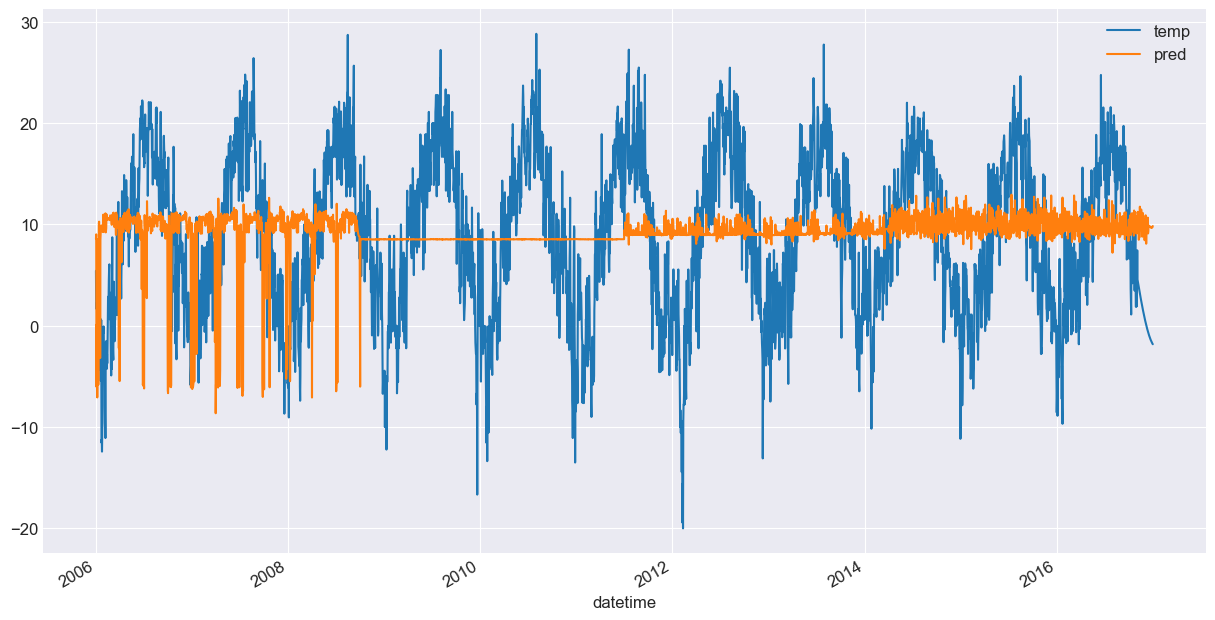

In [35]:
res_df.plot(x = 'datetime', y=['temp', 'pred'])

In [ ]:
chkptPATH = os.path.join(modelDir, subDir, 'all_in_11.keras')
chkpt_cb = tf.keras.callbacks.ModelCheckpoint(chkptPATH,
                                             monitor = 'val_loss',
                                             verbose =2,
                                             save_best_only=True
                                        )

es_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                        verbose =2,
                                        patience= PATIENCE,
                                         restore_best_weights= True
                                        )

lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
                                        monitor = 'val_loss',
                                        factor= LR_FACTOR,
                                        verbose =2,
                                        patience= LR_PATIENCE
                                         )

In [ ]:
history = model.fit(test_ds,#x = X_train, y = y_train, 
                    validation_data = valid_ds,#[X_test, y_test],
                    #batch_size = BATCH_SIZE,
                    verbose = 2,
                    epochs =EPOCHS,
                     callbacks = [chkpt_cb,es_cb,lr_cb]
                   )

In [ ]:
fn_plot_tf_hist(pd.DataFrame(history.history))